# Vessel Emissions API Use Case

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VesselEmissionsAPI/VesselEmissionsAPI-UseCase.ipynb)

## CO2 & CO2 Intensity comparison between different MR and Panamax Tanker routes

In this notebook, we will show a use case of including Vessel Emissions API in your workflow. We will use Voyages API to get all voyages in MR and Panamax Tanker routes for the past two years and then use Vessel Emissions API to get the emissions for these voyages. Finally we will perform some Exploratory Data Analysis on the acquired emissions data and visualize our findings.

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [ ]:
!pip install signal-ocean

In [1]:
signal_ocean_api_key = '' #replace with your subscription key

### Import helpful modules

In [2]:
from datetime import date, timedelta
from tqdm import tqdm

import requests
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import numpy as np
sns.set_theme()
sns.set_style("whitegrid")

## Input Data

### 1. Load route definitions for MR and Panamax Tanker vessels

In [3]:
mr_panamax_tanker_routes = [
    {
        'Type': 'Clean',
        'LoadArea': 'East Mediterranean',
        'DischargeArea': 'Central Mediterranean',
        'VesselClass': 'MR1',
        'VesselClassID': 89,
        'RouteID': 'MR1 - 1'
    },
    {
        'Type': 'Clean',
        'LoadArea': 'Baltic Sea Upper',
        'DischargeArea': 'Continent',
        'VesselClass': 'MR1',
        'VesselClassID': 89,
        'RouteID': 'MR1 - 2'
    },
    {
        'Type': 'Clean',
        'LoadArea': 'West Mediterranean',
        'DischargeArea': 'Central Mediterranean',
        'VesselClass': 'MR1',
        'VesselClassID': 89,
        'RouteID': 'MR1 - 3'
    },
    {
        'Type': 'Clean',
        'LoadArea': 'West Mediterranean',
        'DischargeArea': 'Continent',
        'VesselClass': 'MR1',
        'VesselClassID': 89,
        'RouteID': 'MR1 - 4'
    },
    {
        'Type': 'Dirty',
        'LoadArea': 'Continent',
        'DischargeArea': 'Central Mediterranean',
        'VesselClass': 'MR1',
        'VesselClassID': 89,
        'RouteID': 'MR1 - 5'
    },
    {
        'Type': 'Dirty',
        'LoadArea': 'Baltic Sea Upper',
        'DischargeArea': 'Continent',
        'VesselClass': 'MR1',
        'VesselClassID': 89,
        'RouteID': 'MR1 - 6'
    },
    {
        'Type': 'Clean',
        'LoadArea': 'Black Sea',
        'DischargeArea': 'West Mediterranean',
        'VesselClass': 'MR1',
        'VesselClassID': 89,
        'RouteID': 'MR1 - 7'
    },
    {
        'Type': 'Clean',
        'LoadArea': 'Continent',
        'DischargeArea': 'East Mediterranean',
        'VesselClass': 'MR1',
        'VesselClassID': 89,
        'RouteID': 'MR1 - 8'
    },
    {
        'Type': 'Clean',
        'LoadArea': 'Continent',
        'DischargeArea': 'US Atlantic Coast',
        'VesselClass': 'PanamaxTanker',
        'VesselClassID': 87,
        'RouteID': 'PT - 1'
    },
    {
        'Type': 'Clean',
        'LoadArea': 'Continent',
        'DischargeArea': 'Africa Atlantic Coast',
        'VesselClass': 'PanamaxTanker',
        'VesselClassID': 87,
        'RouteID': 'PT - 2'
    },
    {
        'Type': 'Clean',
        'LoadArea': 'West Mediterranean',
        'DischargeArea': 'US Atlantic Coast',
        'VesselClass': 'PanamaxTanker',
        'VesselClassID': 87,
        'RouteID': 'PT - 3'
    }
]

mr_panamax_tanker_routes_df = pd.DataFrame.from_records(mr_panamax_tanker_routes)

## APIs initialization and definition of helper functions for feature engineering

### Initialize Vessel Emissions API


In [4]:
from signal_ocean import Connection
from signal_ocean.vessel_emissions import VesselEmissionsAPI

connection = Connection(signal_ocean_api_key)
emissions_api = VesselEmissionsAPI(connection)

### Initialize Voyages API

In [5]:
from signal_ocean.voyages import VoyagesAPI

voyages_api = VoyagesAPI(connection)

### Define Helper functions

In [6]:
def get_voyage_load_port(voyage_events):
    return next((e.port_name for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_discharge_port(voyage_events):
    return next((e.port_name for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

def get_voyage_load_area(voyage_events):
    return next((e.area_name_level0 for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_discharge_area(voyage_events):
    return next((e.area_name_level0 for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

def get_voyage_load_area_id(voyage_events):
    return next((e.area_idlevel0 for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_discharge_area_id(voyage_events):
    return next((e.area_idlevel0 for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

def convert_comma_separated_str_to_list(comma_str: str) -> list:
  return [item.strip() for item in comma_str.split(",")]

# Use Case Description

##  Visualizing CO2 Emissions for a number of Tanker routes

#### We will visually explore:

#### 1) CO2 Emissions per Route
#### 2) Average Efficiency Ratio per Route
#### 3) Capacity EEOI per Route
#### 4) Timeseries comparions of Capacity EEOI for three selected Routes

### Get voyages for MR and Panamax Tanker routes over the past 2 years

In [7]:
distinct_vessel_classes = np.unique([route.get('VesselClassID') for route in mr_panamax_tanker_routes])

date_from = date.today() - timedelta(days=2*365)

voyages = {}
for vessel_class_id in tqdm(distinct_vessel_classes):
    voyages[vessel_class_id] = voyages_api.get_voyages(vessel_class_id=vessel_class_id, date_from=date_from)

100%|████████████████████████████████████████████| 2/2 [03:29<00:00, 104.74s/it]


### Load data into a pandas DataFrame and apply feature engineering

In [8]:
voyages_df = pd.DataFrame(v.__dict__ for vessel_class_voyages in voyages.values() for v in vessel_class_voyages)

voyages_df['load_port'] = voyages_df['events'].apply(get_voyage_load_port)
voyages_df['discharge_port'] = voyages_df['events'].apply(get_voyage_discharge_port)

voyages_df['load_area'] = voyages_df['events'].apply(get_voyage_load_area)
voyages_df['discharge_area'] = voyages_df['events'].apply(get_voyage_discharge_area)

voyages_df.loc[voyages_df['trade'] == 'Product', 'trade'] = 'Clean'
voyages_df.loc[voyages_df['trade'] == 'Crude', 'trade'] = 'Dirty'

### Get emisssions for the selected voyages

In [9]:
from requests.exceptions import HTTPError


emissions_per_route = pd.DataFrame()
for route in mr_panamax_tanker_routes:
    route_emissions = []
    load_areas = convert_comma_separated_str_to_list(route.get('LoadArea'))
    discharge_areas = convert_comma_separated_str_to_list(route.get('DischargeArea'))
    vessel_class_id = route.get('VesselClassID')
    trade = route.get('Type')

    voyages_in_route = voyages_df[
            (voyages_df['load_area'].isin(load_areas))\
            & (voyages_df['discharge_area'].isin(discharge_areas))\
            & (voyages_df['vessel_class_id']==vessel_class_id)\
            & (voyages_df['trade']==trade)
    ]

    for voyage in tqdm(voyages_in_route.to_dict(orient='records')):
        # Get emissions for all voyages_in_route
        try:
            voyage_emissions = emissions_api.get_emissions_by_imo_and_voyage_number(
                imo=voyage.get('imo'),
                voyage_number=voyage.get('voyage_number'),
                include_distances=True,
                include_efficiency_metrics=True
          )
            if voyage_emissions:
                route_emissions.append(voyage_emissions.to_dict())
        # except for those that have not been calculated yet
        except HTTPError:
            print(f"Emissions for IMO: {voyage.get('imo')} Voyage Number: {voyage.get('voyage_number')} are not calculated yet")

    if len(route_emissions) > 0:
        route_emissions_df = pd.json_normalize(route_emissions, sep='')
        route_emissions_df['RouteID'] = route.get('RouteID')
        
        emissions_per_route = pd.concat([emissions_per_route, route_emissions_df])

print("Route Emissions: \n")
print(route_emissions[0].keys())
print("\n")
print("Route Emissions DF: \n")
print(route_emissions_df.columns)
print("\n")
print("Emissions per Route: \n")
print(emissions_per_route.columns)
print("\n")

  3%|█▏                                         | 5/186 [00:01<01:02,  2.90it/s]

Emissions for IMO: 9277797 Voyage Number: 120 are not calculated yet


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


### Visuals

#### 1)  CO2 Emissions per Route

In [10]:
emissions_per_route['TransportWork'] = emissions_per_route['DistancesVoyageDistanceTravelled'] * emissions_per_route['Deadweight']
aer_per_route = emissions_per_route.groupby('RouteID').agg({'EmissionsVoyageCO2InTons': np.sum, 'TransportWork': np.sum})
aer_per_route['AER'] = aer_per_route['EmissionsVoyageCO2InTons'] * 10 ** 6 / aer_per_route['TransportWork']
aer_per_route.reset_index(inplace=True)

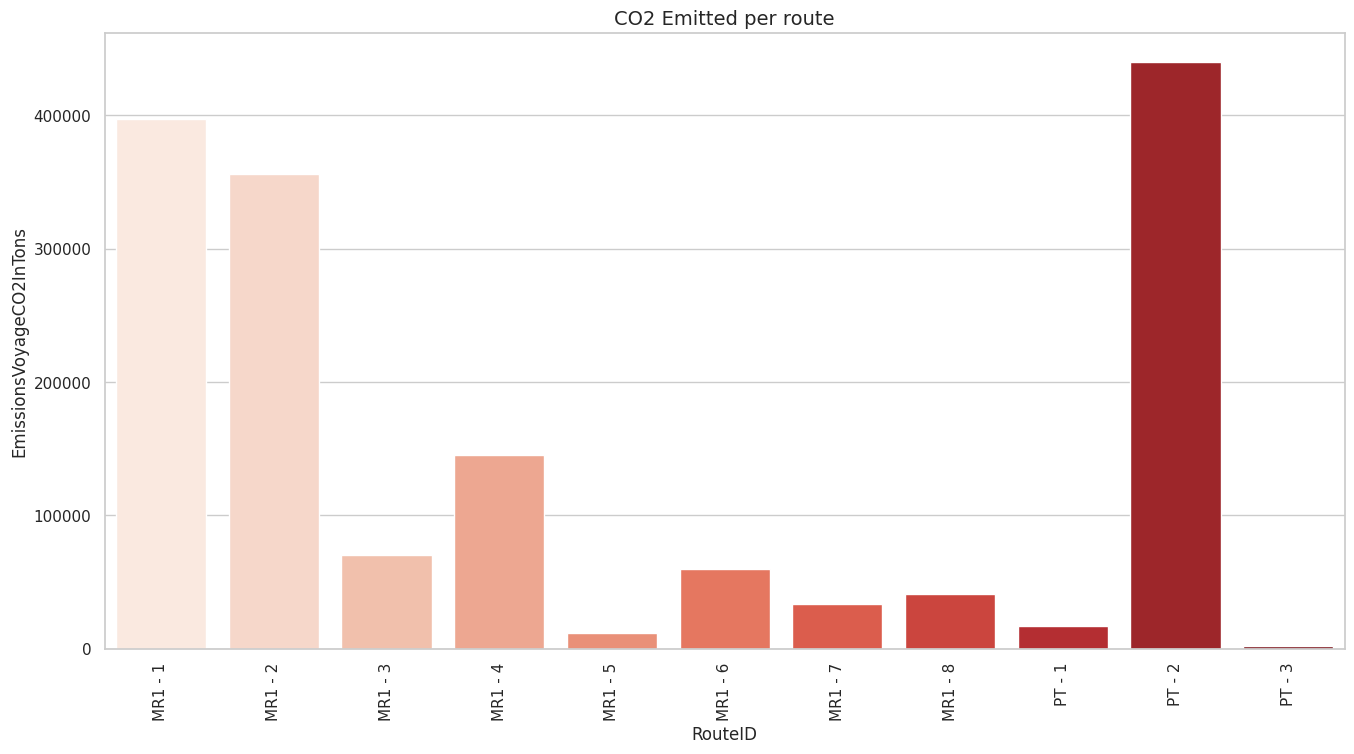

In [11]:
plt.figure(figsize=(16,8))
aer_per_route.sort_values('RouteID', inplace=True)
sns.barplot(x='RouteID', y='EmissionsVoyageCO2InTons', data=aer_per_route, palette='Reds')
plt.xticks(rotation=90)
plt.title('CO2 Emitted per route', fontsize=14)
plt.show()

#### 2) Average Efficiency Ratios per Route

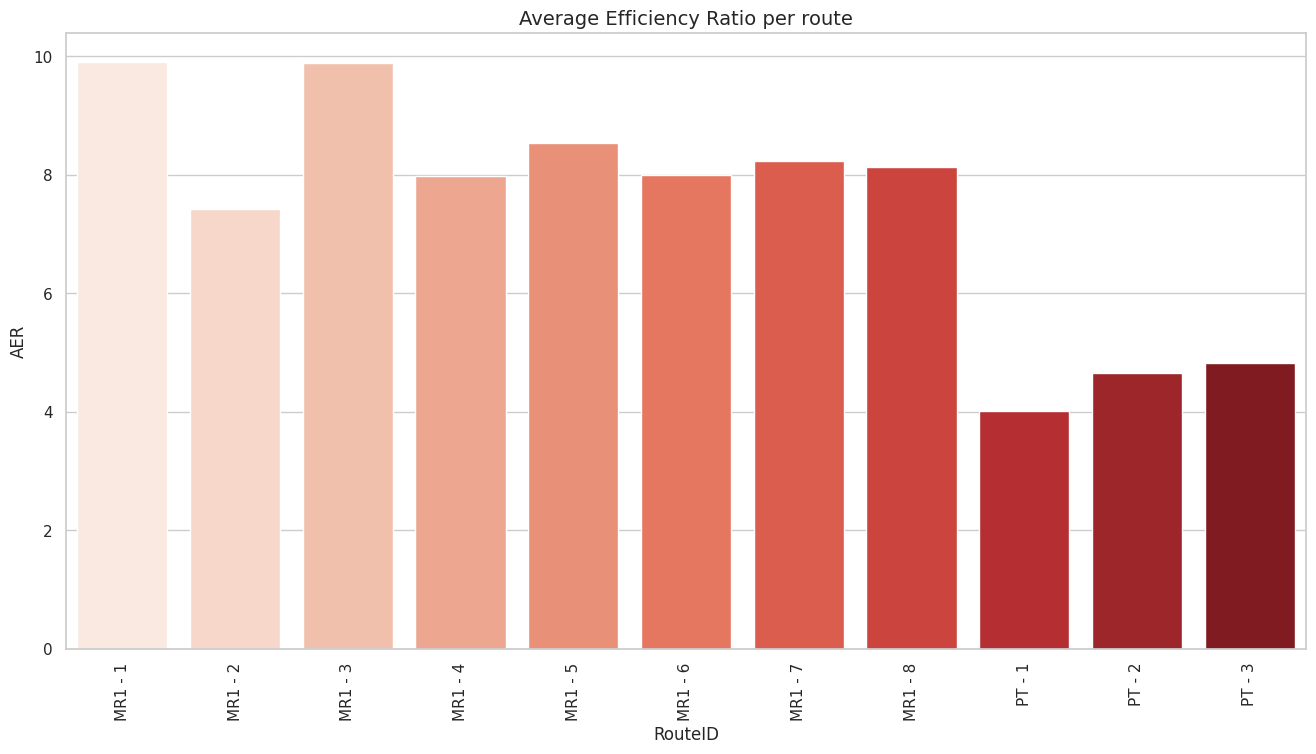

In [12]:
plt.figure(figsize=(16,8))
aer_per_route.sort_values('RouteID', inplace=True)
sns.barplot(x='RouteID', y='AER', data=aer_per_route, palette='Reds')
plt.xticks(rotation=90)
plt.title('Average Efficiency Ratio per route', fontsize=14)
plt.show()

#### 3) Capacity EEOIs per Route

Capacity EEOI is the EEOI metric, considering the vessel is fully loaded (at capacity)

In [13]:
def set_violins_transparency(violins, alpha):
  for violin in violins.get_children():
    if isinstance(violin, PolyCollection):
      violin.set_alpha(alpha)

In [14]:
# Drop outlier values for visual purposes
emissions_to_plot = emissions_per_route[emissions_per_route['EfficiencyMetricsCapacityEeoi'] < emissions_per_route['EfficiencyMetricsCapacityEeoi'].quantile(.99)]

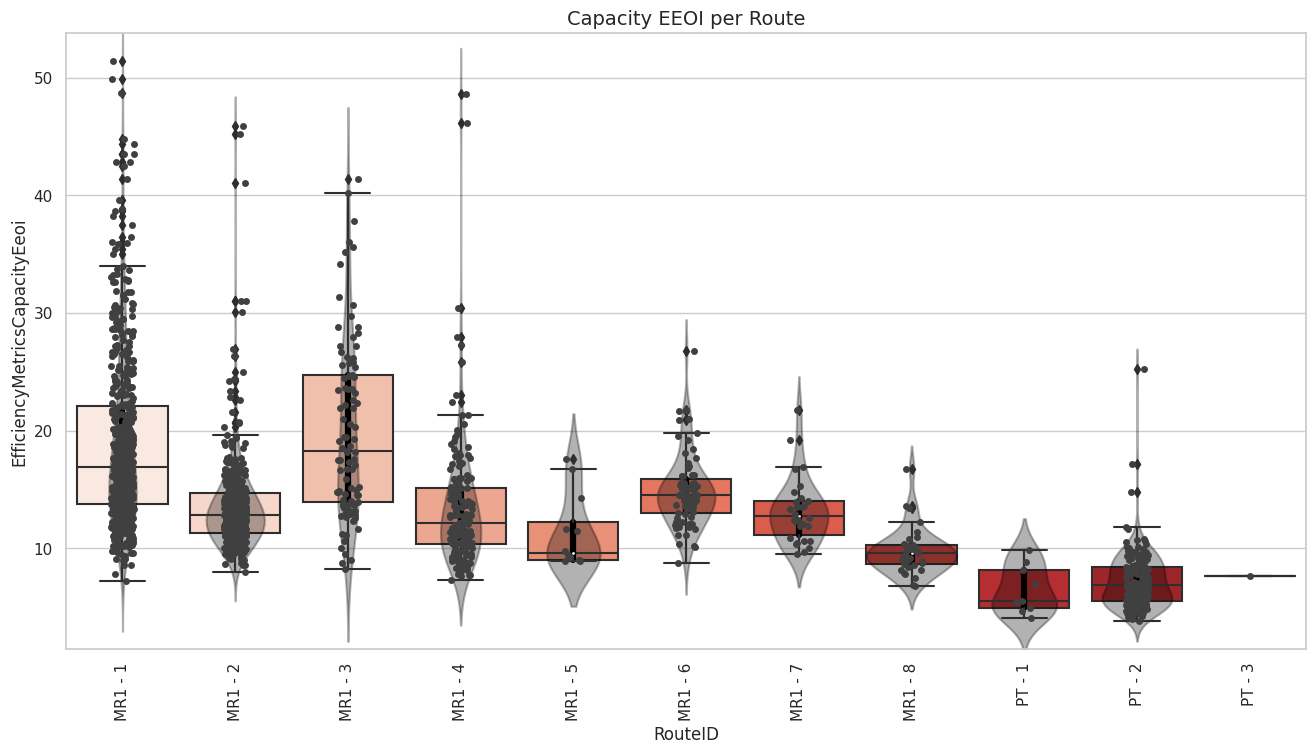

In [15]:
plt.figure(figsize=(16,8))
emissions_per_route.sort_values('RouteID', inplace=True)

violins = sns.violinplot(x='RouteID', y='EfficiencyMetricsCapacityEeoi', data=emissions_to_plot, color=".0")

set_violins_transparency(violins, 0.3)

sns.boxplot(x='RouteID', y='EfficiencyMetricsCapacityEeoi', data=emissions_to_plot, palette="Reds")
sns.stripplot(x='RouteID', y='EfficiencyMetricsCapacityEeoi', data=emissions_to_plot, color=".25")

plt.title("Capacity EEOI per Route", fontsize=14)
plt.xticks(rotation=90)
plt.show()

#### 4) Timeseries visualization of Capacity EEOI

Visualize Capacity EEOI per route, based on when the voyages end

In [16]:
emissions_per_route['EndDate'] = pd.to_datetime(emissions_per_route['EndDate'])
emissions_per_route['EndDateMonth'] = emissions_per_route['EndDate'].apply(lambda x: x.strftime('%Y-%m'))
emissions_per_route['EndDateMonth'] = pd.to_datetime(emissions_per_route['EndDateMonth'])

emissions_per_route = emissions_per_route.merge(mr_panamax_tanker_routes_df[['RouteID', 'LoadArea', 'DischargeArea']], how='left', on='RouteID')

emissions_per_route['RouteInfo'] = emissions_per_route.apply(lambda x: f"{x.VesselClass} - {x.LoadArea} --> {x.DischargeArea}", axis=1)

routes_to_compare = ["MR1 - 1", "MR1 - 2", "PT - 2"]

# Drop outlier values for visual purposes
emissions_to_plot = emissions_per_route[emissions_per_route['EfficiencyMetricsCapacityEeoi'] < emissions_per_route['EfficiencyMetricsCapacityEeoi'].quantile(.99)]

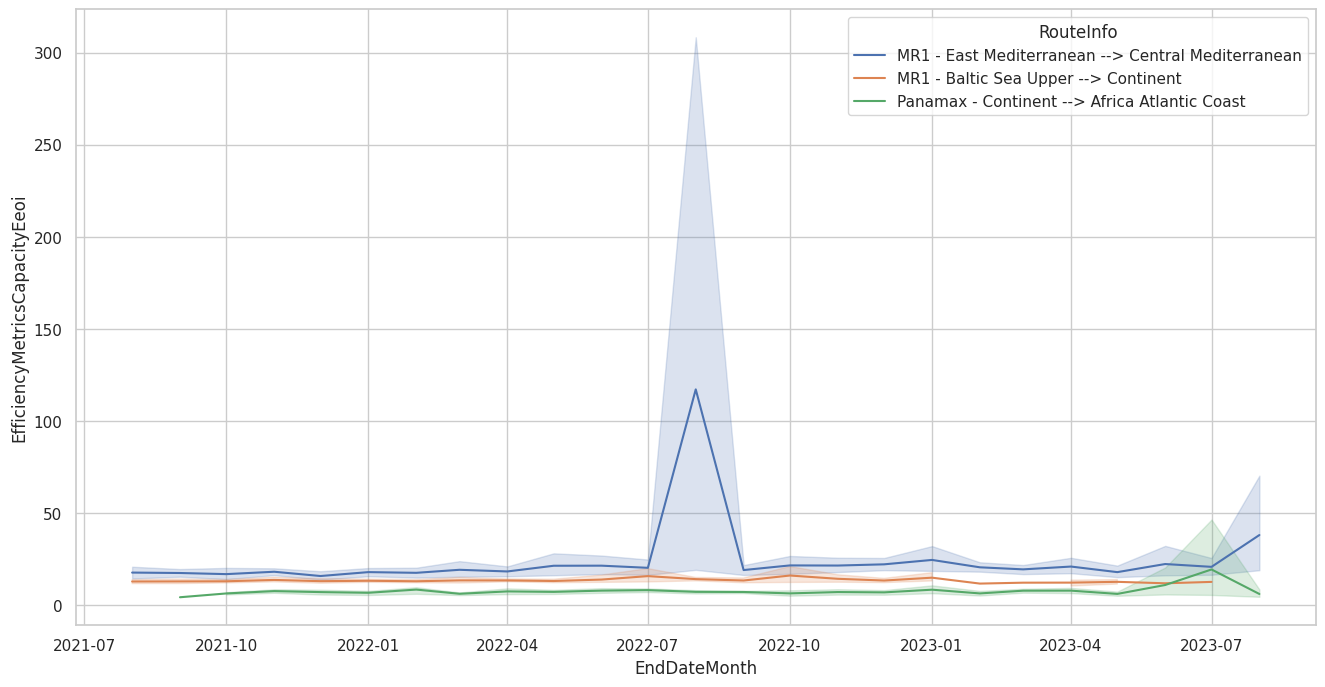

In [17]:
plt.figure(figsize=(16,8))

sns.lineplot(x="EndDateMonth", y="EfficiencyMetricsCapacityEeoi", hue="RouteInfo", data=emissions_per_route[emissions_per_route['RouteID'].isin(routes_to_compare)])
plt.show()